In [103]:

import uuid
from pathlib import Path

import numpy
import seaborn as sns
import torch
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

from dataloaders.tabular import TabularDataset
from experiments.dnn_ae_experiment import DNNAEExperiment
from models.dnn_ae import Autoencoder
from niapy_extension.wrapper import *

### Setup configuration

In [104]:
RUN_UUID = uuid.uuid4().hex

with open("configs/dnn_ae.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

config['logging_params']['save_dir'] += RUN_UUID + '/'
Path(config['logging_params']['save_dir']).mkdir(parents=True, exist_ok=True)
seed_everything(config['exp_params']['manual_seed'], True)
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\utilities\seed.py:48: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v1.10.0. Please use `lightning_lite.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
INFO:lightning_lite.utilities.seed:Global seed set to 1265


### Construct model and experiment

In [105]:
solution = [0.0, 1.0, 0.3238545402477898, 0.0, 0.2770718202737109, 0.6741137338475078, 1.0]
solution = numpy.array(solution)
model = Autoencoder(solution, **config)
saving_path = config['logging_params']['save_dir'] + "manual_alg_" + model.hash_id
Path(saving_path).mkdir(parents=True, exist_ok=True)

+------------------------------------------+-------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
|                    ID                    | Shape (y1)  | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                         Encoder                          |                         Decoder                          |
+------------------------------------------+-------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
| 861ec0923f1cb1a12d38c9d754870da846a5f37e | SYMMETRICAL |       59        |      1      | 

In [106]:
model.num_epochs = 3
early_stop_callback = EarlyStopping(monitor=config['early_stop']['monitor'],
                                    min_delta=config['early_stop']['min_delta'],
                                    patience=config['early_stop']['patience'],
                                    verbose=False,
                                    check_finite=True,
                                    mode="max")

experiment = DNNAEExperiment(model, config['exp_params'], config['model_params']['n_features'])
config['trainer_params']['max_epochs'] = model.num_epochs
tb_logger = TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                              name="manual_alg_" + model.hash_id)

runner = Trainer(logger=tb_logger,
                 enable_progress_bar=False,
                 # accelerator="gpu",
                 # devices=1,
                 # auto_select_gpus=True,
                 callbacks=[
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=1,
                                     dirpath=os.path.join(tb_logger.log_dir, "checkpoints"),
                                     monitor="val_loss",
                                     save_last=True),
                     early_stop_callback,
                 ],
                 # strategy=DDPPlugin(find_unused_parameters=False),
                 **config['trainer_params'])

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'dnn_ae_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['dnn_ae_model'])`.
  rank_zero_warn(
C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (RMSE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `fu

Train and save mode to file

In [107]:
print(f"======= Training {config['model_params']['name']} =======")
print(f'\nTraining start: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
runner.fit(experiment, datamodule=datamodule)
print(f'\nTraining end: {datetime.now().strftime("%H:%M:%S-%d/%m/%Y")}')
torch.save(model.state_dict(), saving_path + "/manual_model.pt")

INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type        | Params
----------------------------------------------------
0 | model               | Autoencoder | 181   
1 | testing_RMSE_metric | RMSE        | 0     
----------------------------------------------------
181       Trainable params
0         Non-trainable params
181       Total params
0.001     Total estimated model params size (MB)
C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, 

======= Training Autoencoder =======

Training start: 17:48:14-26/11/2022


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.



Training end: 17:48:18-26/11/2022


C:\Users\sasop\PycharmProjects\NiaNetHPC\experiments\anomalyDetection.py:29: RuntimeWarning: invalid value encountered in double_scalars
  self.F1 = 2 * ((self.precision * self.recall) / (self.precision + self.recall))


Load model from file

In [108]:
model = Autoencoder(solution, **config)
model.load_state_dict(torch.load(saving_path + "/manual_model.pt"))
#model.load_state_dict(torch.load("logs/add5e7b369a2493e9ec39f428d4c05fd/ParticleSwarmAlgorithm_e1b93f7da8ebc4a6cb5b2084e8c4f7d272b923c4.pt"))
model.eval()

+------------------------------------------+-------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
|                    ID                    | Shape (y1)  | Layer step (y2) | Layers (y3) | Activation func. (y4) | Epochs (y5) | Learning rate (y6) | Optimizer (y7) | Bottleneck size |                         Encoder                          |                         Decoder                          |
+------------------------------------------+-------------+-----------------+-------------+-----------------------+-------------+--------------------+----------------+-----------------+----------------------------------------------------------+----------------------------------------------------------+
| 861ec0923f1cb1a12d38c9d754870da846a5f37e | SYMMETRICAL |       59        |      1      | 

Autoencoder(
  (encoding_layers): ModuleList(
    (0): Linear(in_features=60, out_features=1, bias=True)
  )
  (decoding_layers): ModuleList(
    (0): Linear(in_features=1, out_features=60, bias=True)
  )
)

### Predict with loaded model

In [109]:
# predict with the model
dataloader_iterator = iter(datamodule.test_dataloader())
rmse_list = list()
counter = 0
for data, target in dataloader_iterator:
    data = data.to('cpu')
    reconstructed, input = model.forward(data)
    rmse = mean_squared_error(input.detach().numpy(), reconstructed.detach().numpy(), squared=True)
    rmse_list.append(rmse)
    counter += 1

print(counter)
print(f"Number of elements: {len(rmse_list)}")
print(sum(rmse_list) / len(rmse_list))

53
Number of elements: 53
6.154484283249333


### Calculate AUC value based on anomaly detection

In [121]:
from experiments.anomaly_detection import AnomalyDetection

anomaly_detection = AnomalyDetection([0], [1])
dataloader_iterator = iter(datamodule.test_dataloader())

inputs = []
reconstructs = []
reconstrcution_errors = []
instance_target = []
targets = []

"Loop over dataset"
for data, target in dataloader_iterator:
    data = data.to('cpu')
    reconstructed, input = model.forward(data)

    "Loop over batch"
    for x, y, z in zip(reconstructed, input, target):
        inputs.append(x)
        reconstructs.append(y)
        targets.append(z)
        reconstructed, input = model.forward(data)
        rmse = mean_squared_error(input.detach().numpy(), reconstructed.detach().numpy(), squared=True)
        reconstrcution_errors.append(rmse)
        instance_target.append(z.item())

anomaly_detection.find(inputs, reconstructs, targets)
print(f"Model AUC score: {anomaly_detection.AUC}")

ConfusionMatrix.calculate_area_under_curve() missing 1 required positional argument: 'FPR_array'
Model AUC score: 0.0


C:\Users\sasop\PycharmProjects\NiaNetHPC\experiments\metrics.py:34: RuntimeWarning: invalid value encountered in double_scalars
  self.F1 = 2 * ((self.precision * self.recall) / (self.precision + self.recall))


C:\Users\sasop\AppData\Local\Temp\ipykernel_22208\3978992233.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


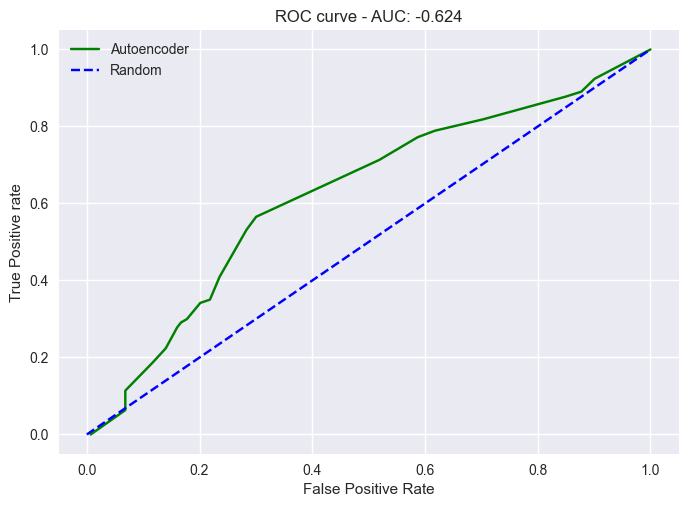

In [111]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve


def plot_roc_curve(y_test, FPR_array, TPR_array, view=False, filename='./logs/roc_curve.png'):
    # https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/
    random_probs = [0 for i in range(len(y_test))]
    p_fpr, p_tpr, thresholds = roc_curve(y_test, random_probs, pos_label=1)

    # This is the ROC curve
    plt.style.use('seaborn')
    # FPR_array = [ round(elem, 2) for elem in FPR_array ]
    # TPR_array = [ round(elem, 2) for elem in TPR_array ]
    # plot roc curves
    plt.plot(FPR_array, TPR_array, linestyle='-', color='green', label='Autoencoder')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random')

    plt.title(f'ROC curve - AUC: {round(np.trapz(TPR_array, FPR_array), 3)}')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


plot_roc_curve(targets, anomaly_detection.FPR_array, anomaly_detection.TPR_array, True)

### 2D Scatter plot (anomalies vs. normal)

In [112]:
datamodule = TabularDataset(**config["data_params"], pin_memory=True)
datamodule.setup()
x = datamodule.test_dataset.x_test.cpu().detach().numpy()
y = datamodule.test_dataset.y_test.cpu().detach().numpy()
x.shape

(530, 60)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


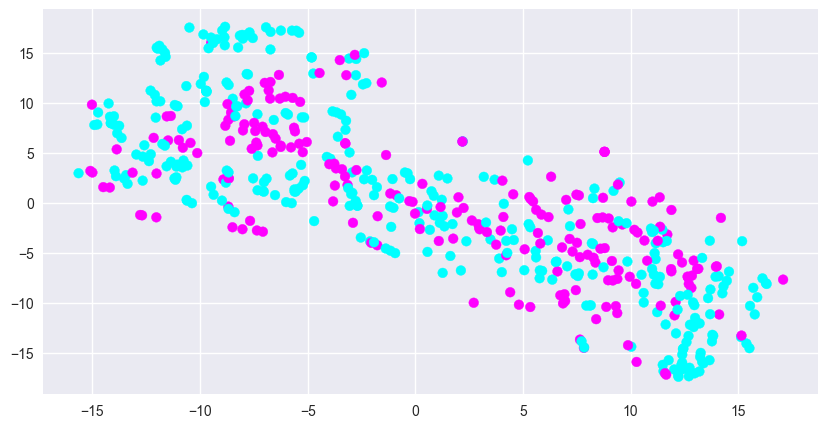

In [113]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=60).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter2D.png', dpi=300)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


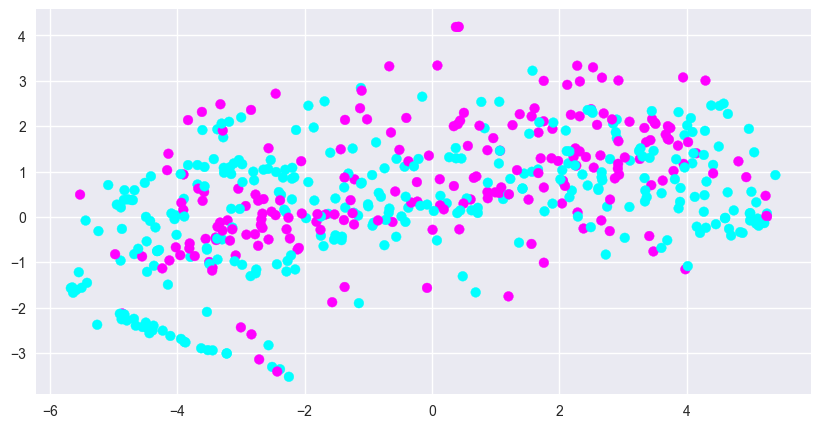

In [114]:
# https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c
X_tsne = TSNE(n_components=2, learning_rate=1000, n_iter=1000, perplexity=200).fit_transform(x)
X_pca = PCA().fit_transform(x)
plt.figure(figsize=(10, 5))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter2D.png', dpi=300)

### 3D Scatter plot (anomalies vs. normal)

C:\Users\sasop\PycharmProjects\NiaNetHPC\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


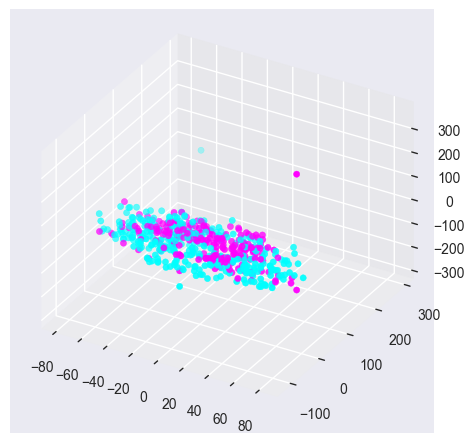

In [115]:
X_tsne = TSNE(n_components=3, learning_rate=250, n_iter=1000, perplexity=10).fit_transform(x)
X_pca = PCA().fit_transform(x)
ax = plt.axes(projection='3d')
# Data for a three-dimensional line
# Data for three-dimensional scattered points
zdata = X_tsne[:, 0]
xdata = X_tsne[:, 1]
ydata = X_tsne[:, 2]
ax.set_proj_type('ortho')
ax.scatter3D(xdata, ydata, zdata, c=y[:x.shape[0]], cmap='cool')
plt.savefig('scatter3D.png', dpi=300)

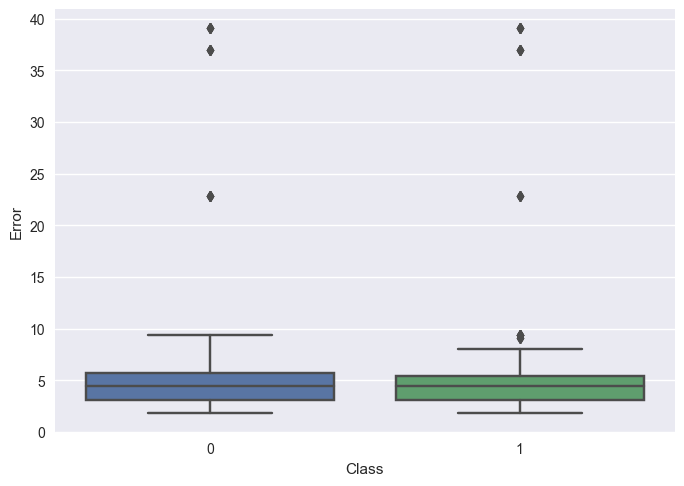

In [116]:
df = pd.DataFrame(list(zip(reconstrcution_errors, instance_target)), columns=['Error', 'Class'])
sns.boxplot(y=df["Error"], x=df["Class"])
plt.show()

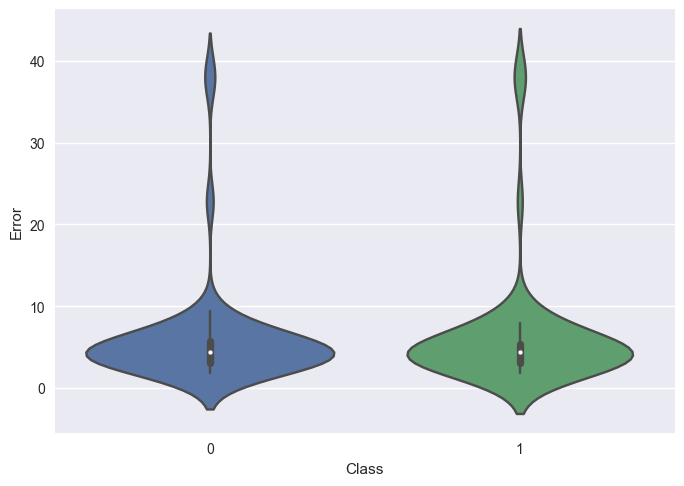

In [117]:
sns.violinplot(y=df["Error"], x=df["Class"], kind="kde")
plt.show()

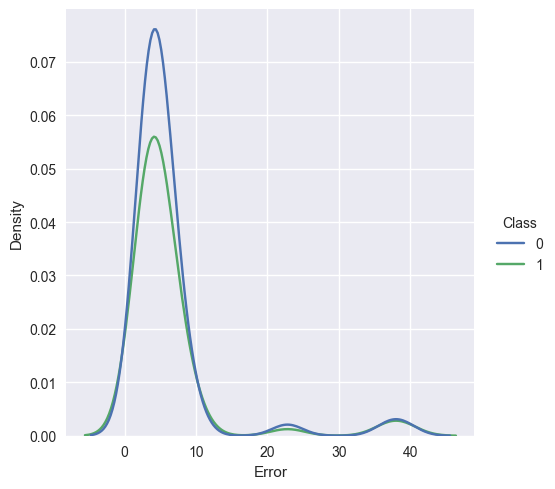

In [118]:
sns.displot(df, x="Error", hue="Class", kind="kde")
plt.show()

In [119]:
df[df.Class == 0].describe()

,Error,Class
count,293.000000,293.0
mean,6.070138,0.0
std,6.764979,0.0
min,1.804350,0.0
25%,3.107772,0.0
50%,4.456094,0.0
75%,5.765923,0.0
max,39.053101,0.0


In [120]:
df[df.Class == 1].describe()

,Error,Class
count,237.000000,237.0
mean,6.258759,1.0
std,7.305710,0.0
min,1.804350,1.0
25%,3.086152,1.0
50%,4.429052,1.0
75%,5.391757,1.0
max,39.053101,1.0
